# Market generator

In [1]:
from tqdm import tqdm
import matplotlib.pyplot as plt
import iisignature
import signatory
import numpy as np
import random
import torch
import datetime
from IPython.display import display

import base
import market_generator
from utils import tosig

In [2]:
def set_seed(seed):
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    random.seed(seed)
    np.random.seed(seed)
    return

set_seed(206)

## Load monthly paths

In [3]:
# Signature order
order = 4

# ^GSPC is S&P 500.
ticker = "^GSPC"
MG = market_generator.MarketGenerator(ticker, start=datetime.date(2000, 1, 1),
                                      freq="M", sig_order=order)

[*********************100%%**********************]  1 of 1 completed
Download data successfully
Shape of downloaded data:(4779, 6)
Apply lead lag transformation...
Shape before lead lag:(20, 6)
Shape after lead lag:(39, 12)
windows length:228
element shape:(39, 12)
Calculate signatures...
We dropout the signatures with nan.
self.logsig shape:(227, 5798)
self.conditions shape:(227, 5798)


Take the above output as an example. In some month between 2000 and 2019, there are 20 transaction days with each data contains 6 columns: open, high, low, close, adj close, and volume. Let $\hat{X}=\{x_{1},...,x_{M}\}$ be the transaction data of the month with $M=20,x_{i}\in\mathbb{R}^6$ in this example.

The lead transformation $\hat{T}(X)_{lead}$ of $\hat{X}$ is defined as
$$
\hat{T}(X)_{lead}=(x_{1},x_{2},x_{2},...,x_{M},x_{M})=(u_1,...,u_{2M-1})\in\mathbb{R}^{6\times 39}
$$
and the lag transformation $\hat{T}(X)_{lag}$ as
$$
\hat{T}(X)_{lag}=(x_{1},x_{1},x_{2},x_{2},...,x_{M-1},x_{M-1},x_{M})=(v_1,...,v_{2M-1})\in\mathbb{R}^{6\times 39}
$$
The lead lag transformation is defined as
$$
\hat{T}(X)=(\hat{T}(X)_{lead},\hat{T}(X)_{lag})\in\mathbb{R}^{12\times 39}.
$$
One may notice that the output shows the shape $39\times 12$, not $12\times 39$. This does not does not affect the performance of neural network since this is just a matter of storing data vertically or horizontally. 


## Plot paths

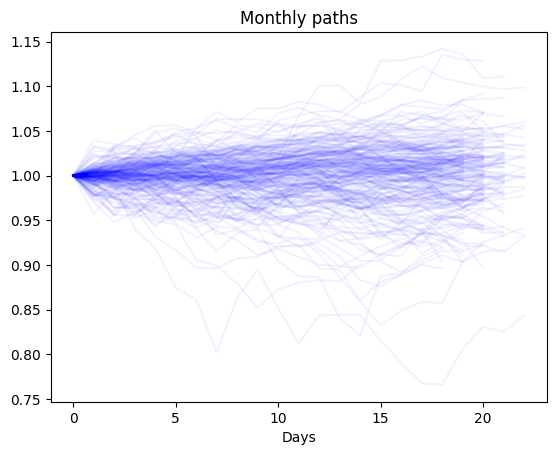

In [4]:
for path in MG.windows:
    temp_path = path.squeeze()
    returns = temp_path[::2, 1] / temp_path[0, 1]
    plt.plot(returns, "b", alpha=0.05)

plt.title("Monthly paths")
plt.xlabel("Days")
plt.show()

## Train generative model

In [5]:
MG.train(n_epochs=10000)

Data shape:torch.Size([227, 5798])
Data condition shape:torch.Size([227, 5798])
Epoch 1 saving model with loss 172469.5625
Epoch 6 saving model with loss 161771.4531
Epoch 7 saving model with loss 126399.5000
Epoch 8 saving model with loss 98454.6719
Epoch 9 saving model with loss 79554.1250
Epoch 10 saving model with loss 68127.6016
Epoch 11 saving model with loss 58015.3125
Epoch 12 saving model with loss 49722.1758
Epoch 13 saving model with loss 42835.5195
Epoch 14 saving model with loss 36215.1602
Epoch 15 saving model with loss 33898.3750
Epoch 20 saving model with loss 31900.7715
Epoch 21 saving model with loss 30002.1348
Epoch 22 saving model with loss 26520.6973
Epoch 23 saving model with loss 24765.3047
Epoch 24 saving model with loss 21582.2051
Epoch 26 saving model with loss 19262.3105
Epoch 28 saving model with loss 16724.5273
Epoch 29 saving model with loss 16220.5596
Epoch 31 saving model with loss 15702.6172
Epoch 32 saving model with loss 14157.6406
Epoch 33 saving mod

## Generate

In [6]:
generated_logsigs = np.array([MG.generate(cond).squeeze() for cond in MG.conditions])

s = iisignature.prepare(12,order,'2')
generated_sigs = np.array([iisignature.logsigtosig(logsig,s) for logsig in generated_logsigs])
real_sigs = np.array([iisignature.logsigtosig(logsig,s) for logsig in MG.logsig])

print(generated_logsigs.shape)
print(generated_sigs.shape)
print(real_sigs.shape)

(227, 5798)
(227, 22620)
(227, 22620)


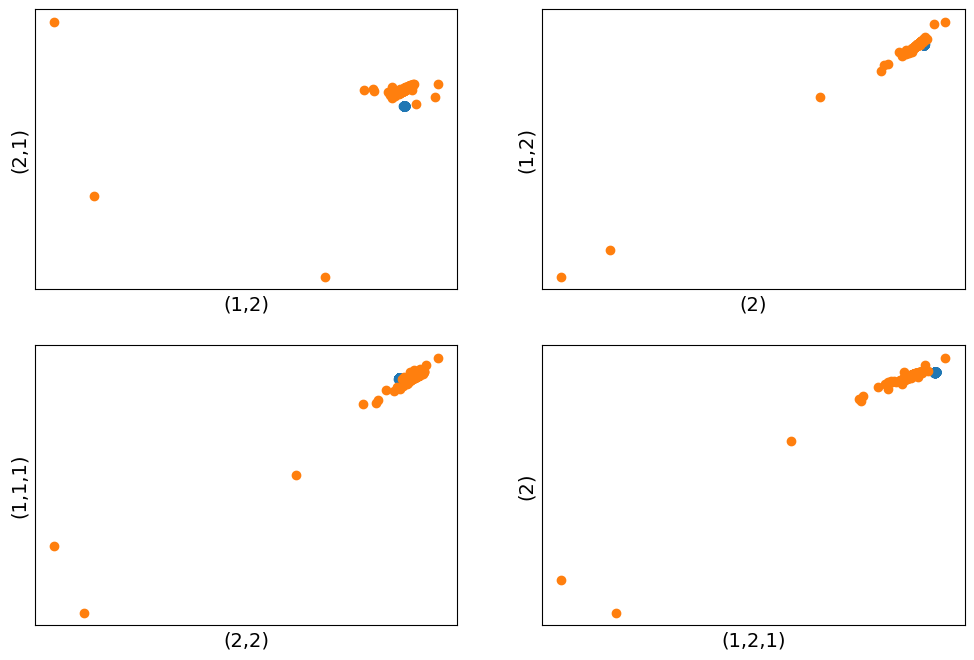

In [7]:
from esig.tosig import sigkeys

keys = sigkeys(2, order).split()

PROJECTIONS = [(4, 5), (2, 4), (6, 7), (9, 2)]

plt.figure(figsize=(12, 8))
for i, projection in enumerate(PROJECTIONS):
    plt.subplot(2, 2, i + 1)

    plt.scatter(real_sigs[:, projection[0]], real_sigs[:, projection[1]],
                label="Real data")
    plt.scatter(generated_sigs[:, projection[0]], generated_sigs[:, projection[1]],
               label="Generated")
    plt.xlabel(keys[projection[0]], fontsize=14)
    plt.ylabel(keys[projection[1]], fontsize=14)
    plt.xticks([])
    plt.yticks([])
    #plt.legend()
    
plt.show()

## Validation: two-sample statistical test

In [9]:
import process_discriminator

s = iisignature.prepare(12,order,'2')
normalised_generated = np.array([MG.generate(cond, normalised=True) for cond in MG.conditions])
sigs1 = np.array([iisignature.logsigtosig(logsig, s).squeeze() for logsig in tqdm(normalised_generated)])
sigs2 = np.array([iisignature.logsigtosig(logsig, s).squeeze() for logsig in tqdm(MG.logsig)])
print("sigs1 shape: {}".format(sigs1.shape))
print("sigs2 shape: {}".format(sigs2.shape))

res = process_discriminator.test(sigs1, sigs2, order=order, compute_sigs=False,
                                 confidence_level=0.99)

print("Are the generated and real distributions DIFFERENT? {}".format(res))

100%|██████████| 227/227 [00:00<00:00, 7716.74it/s]


sigs1 shape: (227, 22620)
sigs2 shape: (227, 22620)


OverflowError: (34, 'Numerical result out of range')

## Invert log-signature

In [11]:
import logsig_inversion
from esig.tosig import stream2logsig
from utils.leadlag import leadlag

logsig = MG.generate(MG.conditions[10]).squeeze()
print(logsig.shape)

(5798,)


In [12]:
pip = 0.01
n_pips = 50 * 100 # 50$
n_points = 21

n_iterations = 100
n_organisms = 100

# Source code:
recovered_path, loss = logsig_inversion.train(logsig, order, n_iterations, n_organisms, n_points,
                                              pip, n_pips)


  0%|          | 0/100 [00:00<?, ?it/s]

sig shape: (5798,)
self.logsignature(order) shape: (8,)


ValueError: operands could not be broadcast together with shapes (5798,) (8,) 

In [ ]:
# Use signatory instead
s = iisignature.prepare(12,4,'2')
sig = iisignature.logsigtosig(logsig,s).reshape(1,-1)
sig = torch.from_numpy(sig)
print("sig shape: {}".format(sig.shape))

# Inversion
recovered_path = signatory.invert_signature(sig,order,12)
print("recovered path shape: {}".format(recovered_path.shape))

Computing signatures of population 1:   0%|          | 0/227 [39:26<?, ?it/s]


ValueError: x and y can be no greater than 2-D, but have shapes (1,) and torch.Size([1, 5, 12])

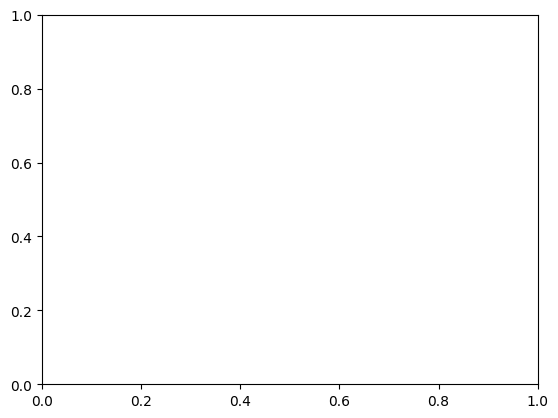

In [ ]:
# Error after invertion of signature using signatory
plt.plot(recovered_path)
plt.show()
print(f"Target log-signature: {logsig.tolist()}")
print(f"Recovered log-signature: {stream2logsig(leadlag(recovered_path), order).tolist()}")

In [ ]:
paths = []
for condition in MG.conditions:
    logsig = MG.generate(condition)
    recovered_path, loss = logsig_inversion.train(logsig, order, n_iterations, n_organisms, n_points,
                                                  pip, n_pips)
    
    paths.append(recovered_path)

In [ ]:
import matplotlib.patches as mpatches

plt.figure(figsize=(8, 6))
for path1, path2 in zip(paths, MG.windows):
    returns = path2[::2, 1][:20] - path2[0, 1]
    plt.plot(returns, "C1", alpha=0.25)

    plt.plot(path1[:20], "C0", alpha=0.25)
    
    
blue_patch = mpatches.Patch(color='C0', label='Generated paths')
red_patch = mpatches.Patch(color='C1', label='Real paths')
plt.legend(handles=[blue_patch, red_patch], fontsize=12)    
plt.xlabel("Days", fontsize=14) 
plt.show()

In [ ]:
returns1 = [path[-1] - path[0] for path in paths]
returns2 = [path[-1, 1] - path[0, 0] for path in MG.windows]

_ = plt.hist([returns1, returns2], bins=20, label=["Real paths", "Generated paths"])
plt.xlabel("Monthly return", fontsize=14)
plt.legend(fontsize=12)
plt.show()

In [ ]:
def concatenate(condition, periods):
    joined_path = None

    for _ in range(periods):
        generated = MG.generate(condition)
        path, loss = logsig_inversion.train(generated, order, n_iterations, n_organisms, n_points,
                                            pip, n_pips)

        condition = tosig.stream2logsig(market_generator.leadlag(recovered_path), order)
        condition = MG.scaler.transform([condition])[0]

        if joined_path is None:
            joined_path = path
        else:
            joined_path = np.r_[joined_path, np.add(path[1:], joined_path[-1])]
            
    return joined_path

In [ ]:
idx = 220

condition = MG.conditions[idx]

paths = [concatenate(condition, 12) for _ in range(10)]

plt.plot(np.transpose(paths))
plt.show()

In [ ]:
plt.plot(MG.windows[idx + 1][0, 0] + np.transpose(paths))
plt.xlabel("Days", fontsize=14) 
plt.show()